# Visualización de Red Neuronal Convolucional con Grad-CAM en el Conjunto de Datos MNIST

In [1]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:,:,:,None]
x_test = x_test[:,:,:,None]

In [2]:
print(x_train.shape)

(60000, 28, 28, 1)


In [3]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

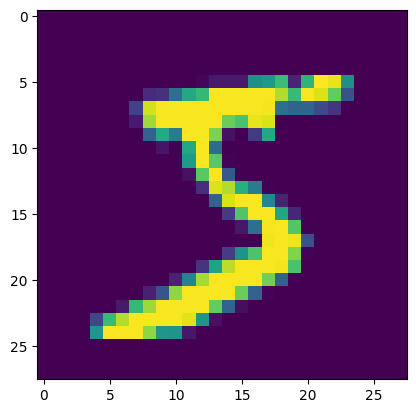

In [4]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0,:,:])

In [5]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [6]:
y_train.shape

(60000, 10)

In [7]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta


def build_cnn(input_shape):
    x = Input(shape=input_shape)
    h = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    h = Conv2D(64, (3,3), activation='relu', padding='same')(h)
    h = MaxPool2D(pool_size=(2,2))(h)
    h = Dropout(0.25)(h)
    h = Flatten()(h)
    h = Dense(128, activation='relu')(h)
    h = Dropout(0.25)(h)
    y = Dense(10, activation='softmax')(h)
    model = Model(inputs=[x], outputs=[y])
    return model

model = build_cnn((28,28,1))
model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['accuracy'])
hist = model.fit(x_train, y_train,
                  batch_size=128,
                  epochs=100,
                  verbose=1,
                  validation_data=(x_test, y_test))

Epoch 1/100
469/469 [==============================] - 14s 14ms/step - loss: 22.2841 - accuracy: 0.1913 - val_loss: 3.6238 - val_accuracy: 0.5747
Epoch 2/100
469/469 [==============================] - 6s 12ms/step - loss: 8.4895 - accuracy: 0.4148 - val_loss: 1.6695 - val_accuracy: 0.7451
Epoch 3/100
469/469 [==============================] - 6s 13ms/step - loss: 4.6587 - accuracy: 0.5385 - val_loss: 1.0590 - val_accuracy: 0.7884
Epoch 4/100
469/469 [==============================] - 6s 12ms/step - loss: 3.1152 - accuracy: 0.5957 - val_loss: 0.7730 - val_accuracy: 0.8034
Epoch 5/100
469/469 [==============================] - 6s 12ms/step - loss: 2.3086 - accuracy: 0.6248 - val_loss: 0.6579 - val_accuracy: 0.8074
Epoch 6/100
469/469 [==============================] - 5s 12ms/step - loss: 1.8487 - accuracy: 0.6344 - val_loss: 0.6384 - val_accuracy: 0.8030
Epoch 7/100
469/469 [==============================] - 6s 12ms/step - loss: 1.5603 - accuracy: 0.6400 - val_loss: 0.6452 - val_accurac

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

Test loss: 0.11051315069198608
Test accuracy: 0.9668999910354614


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                             

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model


def grad_cam(model, img,
             layer_name="block5_conv3", label_name=None,
             category_id=None):

    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id is None:
            category_id = np.argmax(predictions[0])
        if label_name is not None:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return np.squeeze(heatmap)

def grad_cam_plus(model, img,
                  layer_name="block5_conv3", label_name=None,
                  category_id=None):

    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor)
                if category_id is None:
                    category_id = np.argmax(predictions[0])
                if label_name is not None:
                    print(label_name[category_id])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_cam_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    heatmap = np.maximum(grad_cam_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap

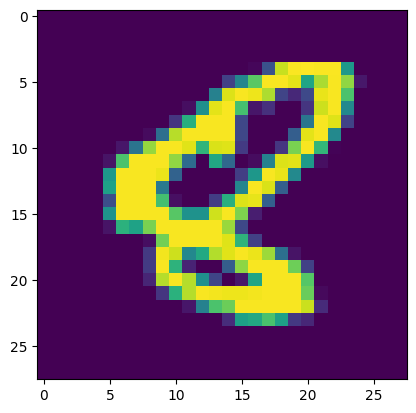

In [19]:
import numpy as np
from keras import backend as K
which_number = 8
y_test_int = np.where(y_test==1)[1]
rand_idx = np.random.choice(np.where(y_test_int == which_number)[0])
test_input = x_test[rand_idx].reshape(1,x_test.shape[1],x_test.shape[2],1)
plt.imshow(test_input.squeeze());


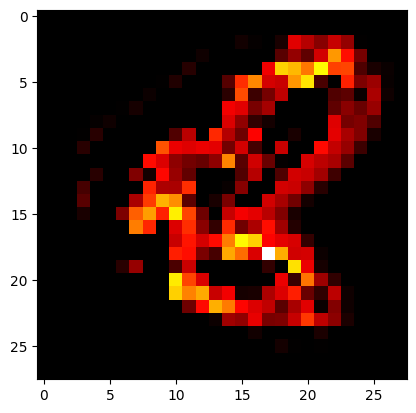

In [78]:
heatmap = grad_cam_plus(model,test_input[0,...],layer_name='conv2d_1')
hm = heatmap-heatmap.min()
hm /= hm.max()
hm *=255
hm = hm.astype('uint8')
hm =  cv2.cvtColor(hm, cv2.COLOR_GRAY2BGR)
hm = cv2.applyColorMap(hm, cv2.COLORMAP_HOT)

plt.imshow(cv2.cvtColor(hm, cv2.COLOR_BGR2RGB) )


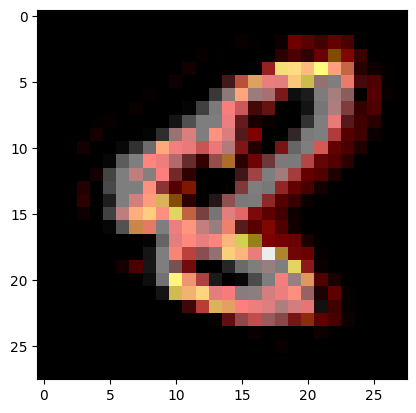

In [79]:
import cv2
img = cv2.cvtColor(test_input[0,...], cv2.COLOR_GRAY2BGR)
super_imposed_img = cv2.addWeighted(hm, .5, img, .5, 0)
plt.imshow(cv2.cvtColor(super_imposed_img, cv2.COLOR_BGR2RGB))